# Fit an euler pole to GPS data

#### Eric Lindsey, 2022

In [1]:
#these two lines make sure our functions will get re-loaded if it changes
%load_ext autoreload
%autoreload 2
# extra line that makes sure our plots appear in the same notebook
%matplotlib inline

# user defined modules
import gps_data
import euler_calc
import geod_transform

# python modules
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# define a function to keep all our 'standard' background map plot commands
def plot_my_custom_map(west,east,south,north):
    fig = plt.figure(figsize=(10, 10))
    m = Basemap(llcrnrlon=west,llcrnrlat=south,urcrnrlon=east,urcrnrlat=north,
                resolution='h', projection='cyl', lat_0 = 21.5, lon_0 = 95.0)
    #merc is for the projection Mercator
    m.drawcoastlines()
    m.drawcountries(color='black')
    # draw parallels
    m.drawparallels(np.arange(-90,90,5),labels=[1,0,0,1],linewidth=0.5)
    # draw meridians
    m.drawmeridians(np.arange(-180,180,5),labels=[1,0,0,1],linewidth=0.5)

    return fig,m

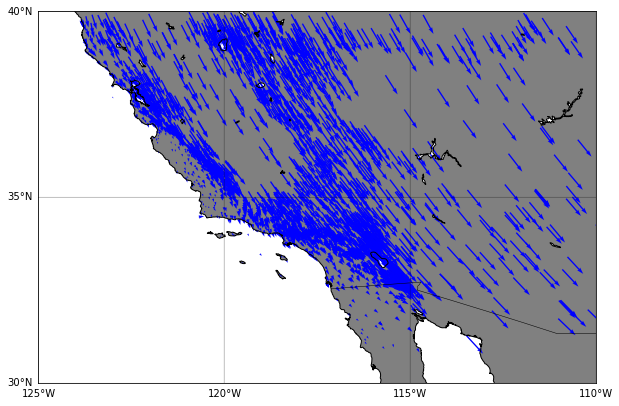

In [2]:
# load and plot initial dataset - example data are compiled by Kreemer et al., 2014

# setup the basemap
west=235
east=250
south=30
north=40
fig,m = plot_my_custom_map(west,east,south,north)

# options for a background color:
#m.shadedrelief()
#m.etopo()
#m.bluemarble()
m.fillcontinents('gray',zorder=-1) 
# note, zorder is needed to make the color appear in the background (lower z value)

# load and plot GPS data
GPS = gps_data.GPSData()
GPS.load_2d_data('ca_gps.gmt')

m.quiver(GPS.lon,GPS.lat,GPS.vE,GPS.vN,color='b', scale=1e3)
plt.show()

# optionally save map as a PDF file
#plt.savefig('gps_vels.pdf',dpi=50,bbox_inches='tight')


**Method 1: Compute pole directly from selected sites**

identified euler pole (lat,lon, deg/myr) [ 48.46909852 -80.71267478   0.82963822]


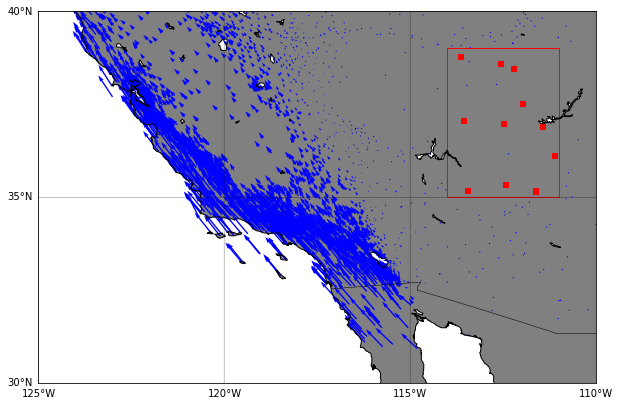

In [3]:
# Select sites on stable NA plate and estimate an euler pole

# bounding box for sites to use in pole estimation. Should be at least 3 sites
latmin=35
latmax=39
lonmin=246
lonmax=249

# use only data with uncertainty less than this value
sigthres=1

# get ID numbers of sites inside the box and with low enough uncertainty
blockids=np.where(np.logical_and(GPS.sigE<sigthres, np.logical_and(GPS.sigN<sigthres, 
                  np.logical_and(GPS.lat>latmin,np.logical_and(GPS.lat<latmax,np.logical_and(GPS.lon>lonmin,GPS.lon<lonmax))))))[0]

blockpole,cov_pole,chi2red=euler_calc.best_fit_pole(GPS.lat[blockids],GPS.lon[blockids],GPS.vE[blockids],GPS.vN[blockids],
                                                            GPS.sigE[blockids],GPS.sigN[blockids],GPS.rhoEN[blockids])

print("identified euler pole (lat,lon, deg/myr)", blockpole)

#plot data on a map
fig,m = plot_my_custom_map(west,east,south,north)
m.fillcontinents('gray',zorder=-1) 

# plot rigidly rotating stations used in fit as red squares
m.plot(GPS.lon[blockids],GPS.lat[blockids],'rs',markersize=5)

# compute the predicted motion for this block relative to the original data
pred_e,pred_n=euler_calc.pole_velocity(GPS.lat,GPS.lon,blockpole[0],blockpole[1],blockpole[2]) 
resid=GPS.calc_resid(pred_e,pred_n)
misfits=GPS.calc_point_misfit(pred_e,pred_n)

#plot transformed velocities
m.quiver(GPS.lon,GPS.lat,GPS.vE - pred_e,GPS.vN - pred_n,color='blue',scale=1e3)

# show the original rectangle
rect = patches.Rectangle((lonmin,latmin), lonmax-lonmin, latmax-latmin, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()


**Method 2: Iteratively update sites used to define pole until they stablilize**

[ 48.46909852 -80.71267478   0.82963822] 1.9483692890904867
[ 48.2512147  -81.04985578   0.8325126 ] 0.39365612358621227
[ 48.21084451 -81.27890751   0.83301784] 0.3978663017910708
[ 48.15911431 -81.50853918   0.83512506] 0.34407045559743127
[ 48.16290917 -81.6062067    0.83433423] 0.33659983166418955
[ 48.28070146 -80.91180142   0.81827967] 0.3975936709260349
[ 48.26272348 -80.80727955   0.8141704 ] 0.3874838317763283
[ 48.2675806  -80.64951836   0.80842035] 0.38160476660386466
[ 48.29767696 -80.56948881   0.80547922] 0.3641926269164119
[ 48.31520372 -80.4943787    0.80317191] 0.36185184487804806
[ 48.37663084 -80.21793353   0.7965534 ] 0.3732472445446157
[ 48.39555583 -80.15033427   0.79349878] 0.36589985929596114
[ 48.41609397 -80.1768056    0.79216125] 0.32918853381666957
[ 48.45151228 -80.05265646   0.78812968] 0.2875263056599873
[ 48.49775941 -79.8895482    0.78319169] 0.2970960555128795
[ 48.41772872 -80.3720665    0.79075294] 0.2790100319516829
[ 48.36934513 -80.61950882   0.79

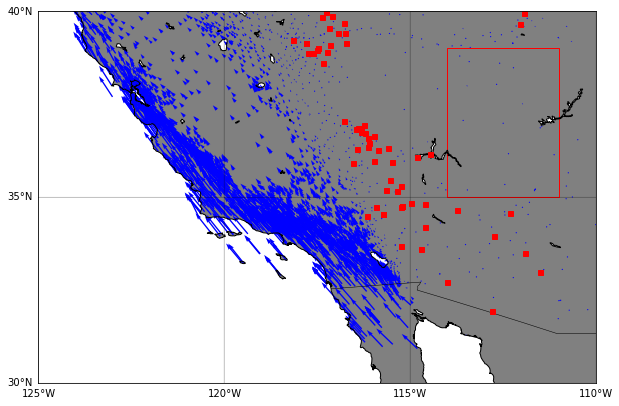

In [4]:
# Select sites on stable NA plate and estimate an euler pole

# bounding box for initial sites to use in pole estimation. Should be at least 3 sites
latmin=35
latmax=39
lonmin=246
lonmax=249

# use only data with uncertainty less than this value
sigthres=1

#criteria for identifying sites that are "really" in the block (rotating rigidly together)
mthres=1.5
maxiter=30

# get ID numbers of sites inside the box and with low enough uncertainty
blockids=np.where(np.logical_and(GPS.sigE<sigthres, np.logical_and(GPS.sigN<sigthres, 
                  np.logical_and(GPS.lat>latmin,np.logical_and(GPS.lat<latmax,np.logical_and(GPS.lon>lonmin,GPS.lon<lonmax))))))[0]

# the function identify_block runs the function best_fit_pole in a loop, updating the list of 
# selected sites each time based on whether their individual misfit is less than the value mthres, 
# until the list stops changing (or the maximum number of iterations is reached)
blockids,blockpole=euler_calc.identify_block(GPS,blockids,sig_thres=sigthres,misfit_thres=mthres,maxiter=maxiter)
   
print("identified euler pole (lat,lon, deg/myr)", blockpole)

#plot data on a map
fig,m = plot_my_custom_map(west,east,south,north)
m.fillcontinents('gray',zorder=-1) 

# plot rigidly rotating stations used in fit as red squares
m.plot(GPS.lon[blockids],GPS.lat[blockids],'rs',markersize=5)

# compute the predicted motion for this block relative to the original data
pred_e,pred_n=euler_calc.pole_velocity(GPS.lat,GPS.lon,blockpole[0],blockpole[1],blockpole[2]) 
resid=GPS.calc_resid(pred_e,pred_n)
misfits=GPS.calc_point_misfit(pred_e,pred_n)

#plot transformed velocities
m.quiver(GPS.lon,GPS.lat,GPS.vE - pred_e,GPS.vN - pred_n,color='blue',scale=1e3)

# show the original rectangle
rect = patches.Rectangle((lonmin,latmin), lonmax-lonmin, latmax-latmin, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()


Interestingly, in this case the final solution did not use any of the originally selected sites. Instead, it selected a more widely distributed set of sites that all appear to move together. The two poles are very similar but differ slightly at the level of precision of these velocities. Try it out on your own dataset and let me know how it works!